In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import json
import kagglehub
import matplotlib.pyplot as plt
from FastCCM.utils import get_td_embedding_np
from sklearn.metrics import pairwise_distances
from FastCCM import PairwiseCCM
from FastCCM import CCM_utils
from manifold_learning import imd_nd_smap, imd_reg_smap


In [2]:

path = kagglehub.dataset_download("jkraak/bitcoin-price-dataset")
btc_price = pd.read_csv(path + "/bitcoin_2017_to_2023.csv")[::-1]


In [3]:
polymarket = pd.read_csv("../src/manifold_learning/data/datasets/number_of_price_changes_across_all_markets.csv",index_col=0)[150000:]

In [4]:
btc_price["timestamp"] = pd.to_datetime(btc_price['timestamp'])
polymarket.index = pd.to_datetime(polymarket.index)

btc_polymarket_df = pd.merge(btc_price, polymarket, left_on='timestamp', right_index=True)
X = np.log(btc_polymarket_df["event_count"]+1).rolling(60).mean().to_numpy()
Y = np.log(btc_polymarket_df["volume"]+1).rolling(60).mean().to_numpy()
#X = (np.log(btc_polymarket_df["event_count"]+1)-np.log(btc_polymarket_df["event_count"]+1).rolling(60).mean().to_numpy())[100:].to_numpy() #(btc_polymarket_df["event_count"].to_numpy())
#Y = (np.log(btc_polymarket_df["volume"]+1)-np.log(btc_polymarket_df["volume"]+1).rolling(60).mean().to_numpy())[100:].to_numpy()

In [5]:
btc_data = btc_price[-300000:].to_numpy()[:,1:].astype(np.float32)
btc_data[:,[1,2,3,4]] = np.log(btc_data[:,[1,2,3,4]]+1)
#btc_data[1:,[0,1,2,4]] = np.diff(btc_data[:,[0,1,2,4]],axis=0) 
btc_data = StandardScaler().fit_transform(btc_data)
#btc_data = btc_data[1:]
btc_data = btc_data[:,[3,1,2,4]]#,9,10,11,12]]

In [6]:
btc_price.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
3125999,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,7564.906851,3,0.075183,320.390851
3125998,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0,0.000000,0.000000
3125997,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1117.542921,2,0.261074,1117.542921
3125996,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,51.171852,3,0.012008,51.171852
3125995,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,599.999338,1,0.140796,599.999338


In [7]:

btc_data_td = get_td_embedding_np(btc_data[:],100,1).copy()#.reshape(-1,50 * 8)
btc_data_td =(btc_data_td - btc_data_td.min(axis=1)[:,None])/(0.001+ btc_data_td.max(axis=1)[:,None] - btc_data_td.min(axis=1)[:,None])
#btc_data_td[:,:,[0,1,2,3]] = (btc_data_td[:,:,[0,1,2,3]] - btc_data_td[:,:,[0,1,2,3]][:,[150]])
#btc_data_td[:,:,[0,1,2,3]] = (btc_data_td[:,:,[0,1,2,3]] / btc_data_td[:,:,[0,1,2,3]].mean(axis=1).std(axis=0)[None,None,:])


btc_data_td = btc_data_td[:,:,3]#.reshape(-1,50 * 4)

In [8]:
X_train = btc_data_td[:-100000:,-50:]
y_train = np.diff(btc_data,axis=0)[:,[3]][-btc_data_td.shape[0]:,:][:-100000]
X_test = btc_data_td[-100000:,-50:]
y_test = np.diff(btc_data,axis=0)[:,[3]][-btc_data_td.shape[0]:,:][-100000:]

y_test /= y_train.std()
y_train /= y_train.std()


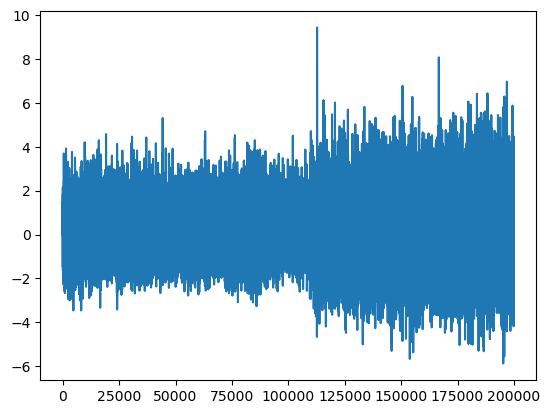

In [9]:
plt.plot(y_train[:,0])

2025-02-08 17:49:36.537861: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-08 17:49:36.560693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-08 17:49:37.065249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


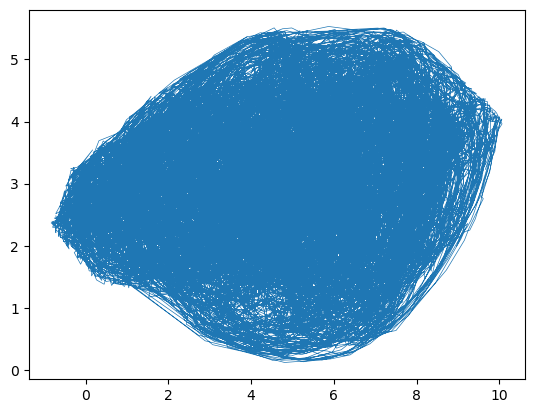

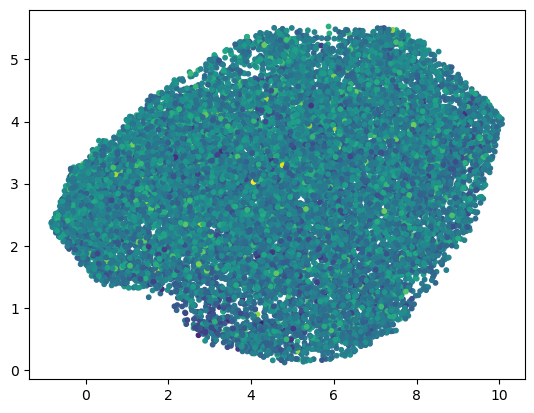

In [10]:
import umap
u = umap.UMAP(n_components=2)
X_umap = u.fit_transform(X_train[:20000])
plt.plot(*X_umap.T,lw=0.5)
plt.show()
plt.scatter(*X_umap.T,c=y_train[1:20001,0],s=10)

In [98]:

trainer = imd_reg_smap.IMD_reg_smap(X_train.shape[1], embed_dim=2, subtract_corr=False, device="cuda")


In [111]:
trainer.fit(X_train, y_train, sample_len=270, library_len=5000,
                exclusion_rad=150,theta=7,tp=0,
                epochs=10000, num_batches=32,optimizer="Adagrad", tp_policy="fixed",learning_rate=0.01)

Epoch 1/10000, Loss: 0.0671
Epoch 2/10000, Loss: 0.0695
Epoch 3/10000, Loss: 0.0672
Epoch 4/10000, Loss: 0.0675
Epoch 5/10000, Loss: 0.0650
Epoch 6/10000, Loss: 0.0682
Epoch 7/10000, Loss: 0.0666
Epoch 8/10000, Loss: 0.0680
Epoch 9/10000, Loss: 0.0652
Epoch 10/10000, Loss: 0.0682
Epoch 11/10000, Loss: 0.0685
Epoch 12/10000, Loss: 0.0668
Epoch 13/10000, Loss: 0.0664
Epoch 14/10000, Loss: 0.0676
Epoch 15/10000, Loss: 0.0687
Epoch 16/10000, Loss: 0.0649
Epoch 17/10000, Loss: 0.0701
Epoch 18/10000, Loss: 0.0692
Epoch 19/10000, Loss: 0.0668
Epoch 20/10000, Loss: 0.0667
Epoch 21/10000, Loss: 0.0703
Epoch 22/10000, Loss: 0.0691
Epoch 23/10000, Loss: 0.0685
Epoch 24/10000, Loss: 0.0686
Epoch 25/10000, Loss: 0.0699
Epoch 26/10000, Loss: 0.0667
Epoch 27/10000, Loss: 0.0704
Epoch 28/10000, Loss: 0.0684
Epoch 29/10000, Loss: 0.0687
Epoch 30/10000, Loss: 0.0702
Epoch 31/10000, Loss: 0.0664
Epoch 32/10000, Loss: 0.0650
Epoch 33/10000, Loss: 0.0674
Epoch 34/10000, Loss: 0.0661
Epoch 35/10000, Loss: 0

KeyboardInterrupt: 

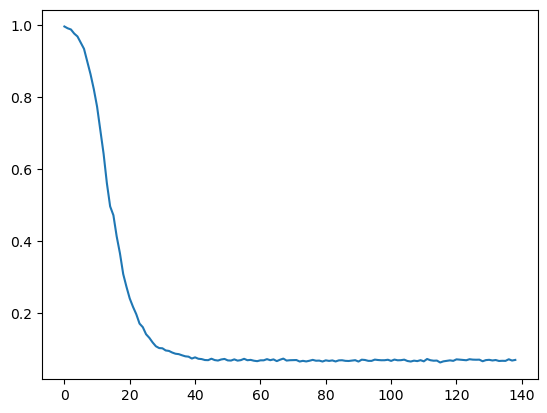

In [112]:
plt.plot(trainer.get_loss_history())

In [113]:
unmixed_train = trainer.predict(X_train)
unmixed_test = trainer.predict(X_test)

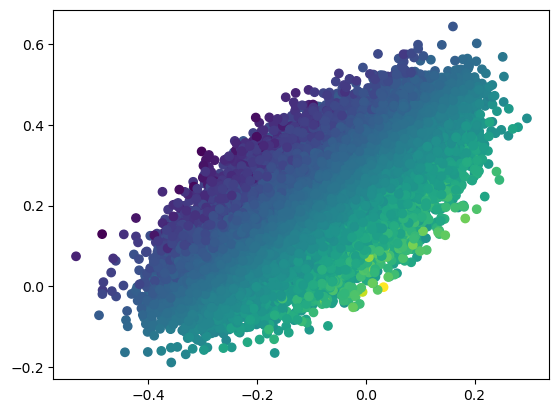

In [114]:
plt.scatter(unmixed_train[:,0,0],unmixed_train[:,0,1],c=y_train[:])

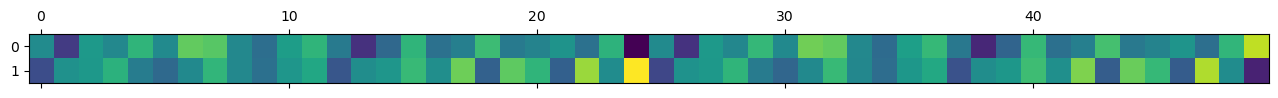

In [118]:
plt.matshow(trainer.model.get_weights()[:,0].T)

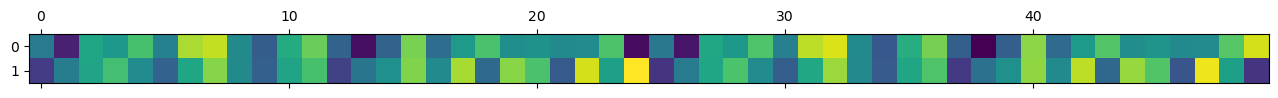

In [119]:
plt.matshow(np.linalg.pinv(trainer.model.get_weights()[:,0]))

2025-02-08 18:35:31.971312: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-08 18:35:31.997717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-08 18:35:32.559763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


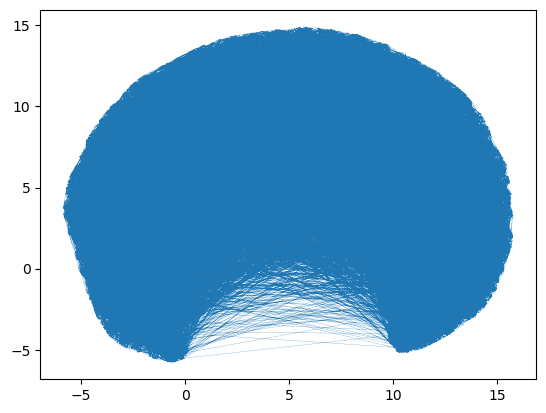

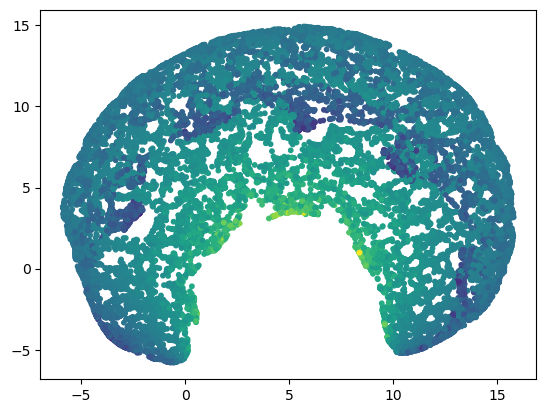

In [120]:
import umap
u = umap.UMAP(40,n_components=2)
X_umap = u.fit_transform(unmixed_train[0:20000,0])
plt.plot(*X_umap.T,lw=0.15)
plt.show()
plt.scatter(*X_umap.T,c=y_train[:20000,0],s=10)

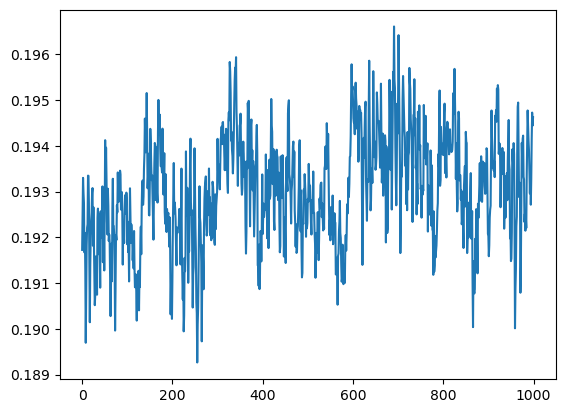

In [81]:
plt.plot(unmixed_train[:1000,0,0])

In [82]:
PairwiseCCM("cpu").compute(np.transpose(unmixed_train,(1,0,2)), y_train[None,:,[0]],5000,1000,20,2,"smap",theta=5)

array([[[0.0676767]]], dtype=float32)

In [84]:
PairwiseCCM("cpu").compute(np.transpose(unmixed_test,(1,0,2)), y_test[None,:,[0]],5000,1000,20,0,"smap",theta=5)

array([[[0.44771707]]], dtype=float32)

In [309]:

temp_pred = np.array([
        (PairwiseCCM("cpu").predict(np.transpose(unmixed_test,(1,0,2)), y_test[None,:,[0]][:,:],2000,150,1,"smap",theta=5).squeeze()) 
        for i in range(10)
    ]).mean(axis=0)

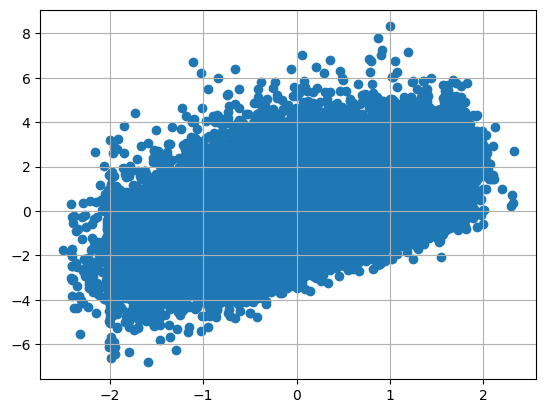

In [310]:
plt.scatter(temp_pred, y_test[1:,0])
plt.grid()

In [311]:

from scipy.stats import pearsonr, spearmanr


# Calculate Pearson correlation coefficient and p-value
r, p_value = pearsonr(temp_pred, y_test[1:,0])

print("Correlation coefficient (r):", r)
print("P-value:", p_value)


Correlation coefficient (r): 0.535036375685095
P-value: 0.0


Correlation Metrics by Bin:
      pearson  spearman  median_y_test
bin                                   
0    0.303713  0.272145      -2.997417
1    0.062092  0.059338      -2.335905
2    0.061620  0.065405      -1.996043
3    0.040319  0.036897      -1.762102
4   -0.005212 -0.010478      -1.570447
5   -0.018633 -0.022478      -1.411781
6    0.007132  0.008852      -1.274799
7    0.012325  0.009831      -1.149693
8   -0.013200 -0.004346      -1.039533
9    0.004731  0.008987      -0.931687
10   0.036612  0.029598      -0.831832
11   0.026604  0.020932      -0.736580
12  -0.001986 -0.003364      -0.647444
13  -0.019589 -0.021198      -0.561318
14  -0.023452 -0.023032      -0.480765
15   0.023433  0.026287      -0.397788
16  -0.013648 -0.008122      -0.318388
17  -0.003820 -0.006829      -0.240951
18  -0.017560 -0.015590      -0.163212
19   0.003146  0.004934      -0.087038
20   0.009769  0.007073      -0.007825
21   0.025422  0.023988       0.074316
22   0.005539 -0.003439       0.1524

/tmp/ipykernel_42024/1824717758.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bin_corr = df.groupby('bin').apply(compute_prediction_corrs)


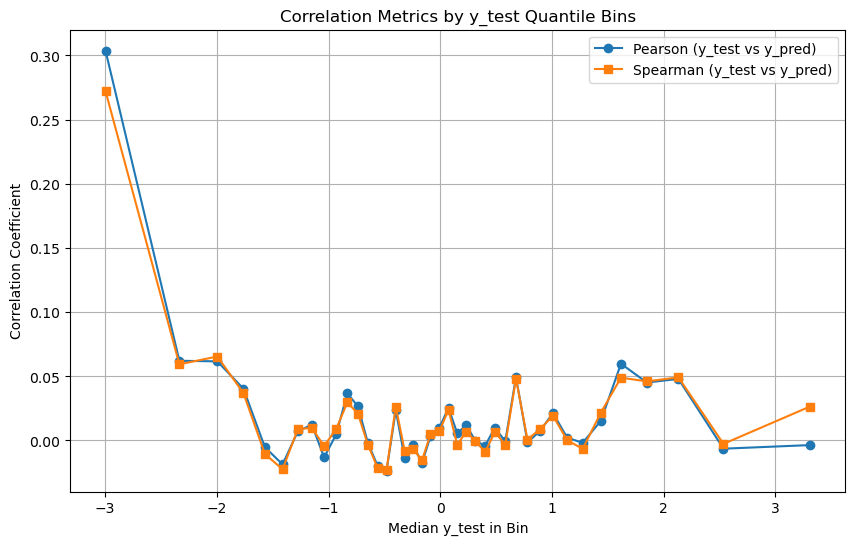

In [312]:

from scipy import stats

# Assume y_test and y_pred are numpy arrays or pandas Series
df = pd.DataFrame({'y_test': y_test[1:,0], 'y_pred': temp_pred})

# ----------------------------------------
# 2. Bin the Data Using Quantile-based Binning
# ----------------------------------------
# Using 4 bins (quartiles) as an example
df['bin'] = pd.qcut(df['y_test'], q=40, labels=False)

# ----------------------------------------
# 3. Compute Correlations in Each Bin
# ----------------------------------------

# Function to compute Pearson and Spearman correlation between y_test and y_pred in a group
def compute_prediction_corrs(group):
    # Ensure enough data points for a reliable correlation
    if len(group) < 2:
        return pd.Series({'pearson': np.nan, 'spearman': np.nan})
    pearson_corr, _ = pearsonr(group['y_test'], group['y_pred'])
    spearman_corr, _ = spearmanr(group['y_test'], group['y_pred'])
    return pd.Series({'pearson': pearson_corr, 'spearman': spearman_corr})

# Compute correlations per bin
bin_corr = df.groupby('bin').apply(compute_prediction_corrs)

# Compute the median of y_test per bin (for plotting)
bin_corr['median_y_test'] = df.groupby('bin')['y_test'].median()


print("Correlation Metrics by Bin:")
print(bin_corr)

# ----------------------------------------
# 4. Visualization
# ----------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(bin_corr['median_y_test'], bin_corr['pearson'], marker='o', linestyle='-', label='Pearson (y_test vs y_pred)')
plt.plot(bin_corr['median_y_test'], bin_corr['spearman'], marker='s', linestyle='-', label='Spearman (y_test vs y_pred)')
plt.xlabel('Median y_test in Bin')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Metrics by y_test Quantile Bins')
plt.legend()
plt.grid(True)
plt.show()


(0.0, 100.0)

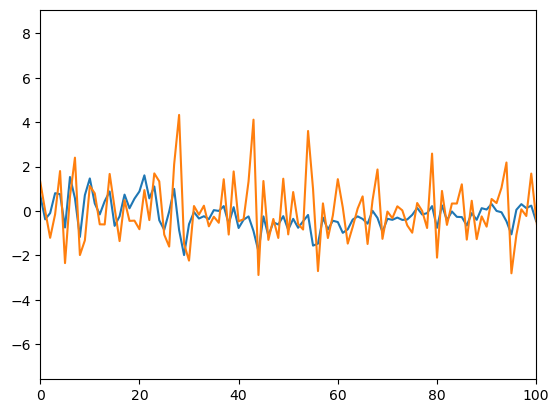

In [313]:
plt.plot(temp_pred[:])
plt.plot(y_test[1:,0])
plt.xlim(0,100)

In [38]:
n_exp = 30
models = []
unmixed_train_all = []
unmixed_test_all = []

for exp in range(n_exp):
        
        trainer = imd_reg_smap.IMD_reg_smap(X_train.shape[1], embed_dim=20, subtract_corr=False, device="cuda")
        trainer.fit(X_train, y_train, sample_len=270, library_len=5000,
        exclusion_rad=150,theta=5,tp=3,
        epochs=100, num_batches=32,optimizer="Adagrad", tp_policy="range",learning_rate=0.01)

        models += [trainer.model]

        unmixed_train = trainer.predict(X_train)
        unmixed_test = trainer.predict(X_test)
        unmixed_train_all += [unmixed_train.copy()]
        unmixed_test_all += [unmixed_test.copy()]


Epoch 1/100, Loss: 0.9833
Epoch 2/100, Loss: 0.9683
Epoch 3/100, Loss: 0.9627
Epoch 4/100, Loss: 0.9515
Epoch 5/100, Loss: 0.9339
Epoch 6/100, Loss: 0.9347
Epoch 7/100, Loss: 0.9269
Epoch 8/100, Loss: 0.9147
Epoch 9/100, Loss: 0.9145
Epoch 10/100, Loss: 0.9240
Epoch 11/100, Loss: 0.9106
Epoch 12/100, Loss: 0.9223
Epoch 13/100, Loss: 0.9114
Epoch 14/100, Loss: 0.9164
Epoch 15/100, Loss: 0.9172
Epoch 16/100, Loss: 0.9211
Epoch 17/100, Loss: 0.9186
Epoch 18/100, Loss: 0.9015
Epoch 19/100, Loss: 0.9092
Epoch 20/100, Loss: 0.9182
Epoch 21/100, Loss: 0.9158
Epoch 22/100, Loss: 0.9148
Epoch 23/100, Loss: 0.9120
Epoch 24/100, Loss: 0.9046
Epoch 25/100, Loss: 0.9156
Epoch 26/100, Loss: 0.9101
Epoch 27/100, Loss: 0.9057
Epoch 28/100, Loss: 0.9107
Epoch 29/100, Loss: 0.9057
Epoch 30/100, Loss: 0.9210
Epoch 31/100, Loss: 0.9077
Epoch 32/100, Loss: 0.9150
Epoch 33/100, Loss: 0.9153
Epoch 34/100, Loss: 0.9147
Epoch 35/100, Loss: 0.9040
Epoch 36/100, Loss: 0.9092
Epoch 37/100, Loss: 0.9066
Epoch 38/1

KeyboardInterrupt: 

In [39]:
unmixed_train_all_concat = np.concatenate([np.transpose(i,(1,0,2)) for i in unmixed_train_all])
unmixed_test_all_concat = np.concatenate([np.transpose(i,(1,0,2)) for i in unmixed_test_all])

In [40]:

ccm_unmixed_train = PairwiseCCM().compute(unmixed_train_all_concat,unmixed_train_all_concat,1500,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0)
ccm_unmixed_test = PairwiseCCM().compute(unmixed_test_all_concat,unmixed_test_all_concat,1500,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0)

ccm_unmixed_train[ccm_unmixed_train<0]=0
ccm_unmixed_test[ccm_unmixed_test<0]=0


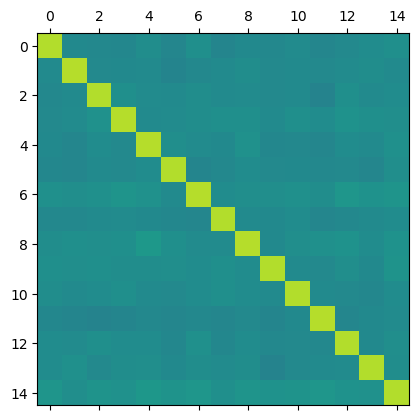

In [41]:


plt.matshow(ccm_unmixed_train,vmin=0,vmax=1)


In [10]:

trainer = imd_nd_smap.IMD_nD_smap(X_train.shape[1], embed_dim=10, n_components=3, subtract_corr=True, device="cuda")

trainer.fit(X_train, sample_len=270, library_len=700, 
                exclusion_rad=150, theta=5, tp=10, 
                epochs=1000, num_batches=32,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=None)

Epoch 1/1000, Loss: 1.1129
Epoch 2/1000, Loss: 1.0295
Epoch 3/1000, Loss: 0.9803
Epoch 4/1000, Loss: 0.9571
Epoch 5/1000, Loss: 0.9371
Epoch 6/1000, Loss: 0.9094
Epoch 7/1000, Loss: 0.8862
Epoch 8/1000, Loss: 0.8669
Epoch 9/1000, Loss: 0.8411
Epoch 10/1000, Loss: 0.8226
Epoch 11/1000, Loss: 0.8031
Epoch 12/1000, Loss: 0.7847
Epoch 13/1000, Loss: 0.7698
Epoch 14/1000, Loss: 0.7544
Epoch 15/1000, Loss: 0.7406
Epoch 16/1000, Loss: 0.7254
Epoch 17/1000, Loss: 0.7157
Epoch 18/1000, Loss: 0.7042
Epoch 19/1000, Loss: 0.6930
Epoch 20/1000, Loss: 0.6840
Epoch 21/1000, Loss: 0.6742
Epoch 22/1000, Loss: 0.6622
Epoch 23/1000, Loss: 0.6526


KeyboardInterrupt: 

In [12]:
trainer.normalize_weights(X_train, sample_len=270, library_len=700, 
                exclusion_rad=150, theta=5, tp=10, 
                epochs=1000, num_batches=32,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=None)

Epoch 1/1000, Loss: 0.4735
Epoch 2/1000, Loss: 0.4707
Epoch 3/1000, Loss: 0.4679
Epoch 4/1000, Loss: 0.4647
Epoch 5/1000, Loss: 0.4635
Epoch 6/1000, Loss: 0.4597
Epoch 7/1000, Loss: 0.4587
Epoch 8/1000, Loss: 0.4572
Epoch 9/1000, Loss: 0.4545
Epoch 10/1000, Loss: 0.4547
Epoch 11/1000, Loss: 0.4527


KeyboardInterrupt: 